### Identifying Bias

#### **Method 1: Independent Demographic Parity**

#### STEP 1.1: Fit data to a random forest regressor 

In [1541]:
import pandas as pd

df = pd.read_csv('PCA_final.csv')

X = df[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
            'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population']]
y = df['inc_case']

In [1542]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (594, 13), y_train shape: (594,)
X_test shape: (255, 13), y_test shape: (255,)


In [1543]:
from sklearn.ensemble import RandomForestRegressor

# Define an Random Forest object using RandomForestRegressor 
rf_model = RandomForestRegressor()

# Fit the model
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [1544]:
# Make predictions
y_pred = rf_model.predict(X_test)

#### STEP 1.2: Separate between red and blue states

In [1545]:
from sklearn.metrics import mean_squared_error

# Separate the prediction into two groups
df['is_liberal'] = df['liberalism'] > 0

is_liberal = df['is_liberal'].iloc[X_test.index]

# Put the actual and predicted values into a DataFrame
y_test_pred = pd.DataFrame({'actual': y_test, 'predicted': y_pred, 'is_liberal': is_liberal})

display(y_test_pred)

,actual,predicted,is_liberal
512,65893.000,83465.040,False
357,609983.000,1033487.870,False
110,8302.000,9097.470,False
684,66373.000,114351.800,False
39,11107.000,12908.520,False
...,...,...,...
450,30087.000,21730.320,True
193,3856.000,3565.010,True
795,46705.000,15512.650,True
605,221513.000,168839.580,True


#### STEP 1.3: Calculate Demographic Parity

In [1546]:
# Calculated the absolute average error for liberal and conservative states
liberal_pred = y_test_pred[y_test_pred['is_liberal'] == True]
liberal_pred_error = (abs(liberal_pred['actual'] - liberal_pred['predicted'])).mean()

conservative_pred = y_test_pred[y_test_pred['is_liberal'] == False]
conservative_pred_error = (abs(conservative_pred['actual'] - conservative_pred['predicted'])).mean()

print(f"Liberal Average Error: {liberal_pred_error}")
print(f"Conservative Average Error: {conservative_pred_error}")
      
demographic_parity_diff = liberal_pred_error - conservative_pred_error
print(f"Demographic Parity Difference: {demographic_parity_diff}")

# Model's predictions are 16000 cases more erroneous for liberal states compared to conservative states.

Liberal Average Error: 35917.01111940299
Conservative Average Error: 18798.58487603306
Demographic Parity Difference: 17118.42624336993


#### STEP 1.4: Calculate differences between evaluation metrics between liberal (blue) and conservative (red) states

In [1547]:
import numpy as np

def calculate_coverage_bias(actual, predicted):
    coverage = np.mean((predicted >= actual.min()) & (predicted <= actual.max()))
    bias = np.mean(predicted - actual)
    return coverage, bias

grouped_rmse = y_test_pred.groupby('is_liberal').apply(lambda x: np.sqrt(mean_squared_error(x['actual'], x['predicted'])))

grouped_coverage_bias = y_test_pred.groupby('is_liberal').apply(lambda x: pd.Series(calculate_coverage_bias(x['actual'], x['predicted']), index=['coverage', 'bias']))

grouped_mse = y_test_pred.groupby('is_liberal').apply(lambda x: mean_squared_error(x['actual'], x['predicted']))

grouped_mse, grouped_rmse, grouped_coverage_bias

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_31048/4027890205.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_rmse = y_test_pred.groupby('is_liberal').apply(lambda x: np.sqrt(mean_squared_error(x['actual'], x['predicted'])))
/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_31048/4027890205.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_coverage_bias = y_test

(is_liberal
 False    2429224386.999
 True    10517228922.325
 dtype: float64,
 is_liberal
 False    49287.162
 True    102553.542
 dtype: float64,
             coverage       bias
 is_liberal                     
 False          0.992   7940.666
 True           1.000 -13296.133)

In [1548]:
metrics_df = pd.DataFrame({
    'MSE': grouped_mse,
    'RMSE': grouped_rmse,
    'Coverage': grouped_coverage_bias['coverage'],
    'Bias': grouped_coverage_bias['bias']
})

metrics_df.index = ['Conservative', 'Liberal']

pd.set_option('display.float_format', lambda x: '%.2f' % x)

metrics_df

,MSE,RMSE,Coverage,Bias
Conservative,2429224387.00,49287.16,0.99,7940.67
Liberal,10517228922.33,102553.54,1.00,-13296.13


#### EXTRA STEP: Calculate Disparate Impact Ratio

In [1549]:
rmse_conservative = metrics_df.loc['Conservative', 'RMSE']
rmse_liberal = metrics_df.loc['Liberal', 'RMSE']

# Compute Disparate Impact (DI) ratio using RMSE
DI_ratio = rmse_conservative / rmse_liberal
print("Disparate Impact (DI) Ratio (RMSE):", DI_ratio)

# Compute Disparate Impact (DI) ratio using bias
bias_conservative = metrics_df.loc['Conservative', 'Bias']
bias_liberal = metrics_df.loc['Liberal', 'Bias']   

DI_ratio_bias = bias_conservative / bias_liberal
print("Disparate Impact (DI) Ratio (Bias):", DI_ratio_bias)

Disparate Impact (DI) Ratio (RMSE): 0.4805993207377606
Disparate Impact (DI) Ratio (Bias): -0.5972161663611443


/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_31048/18864287.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df['MSE'], ax=axes[0, 0], palette="Blues_d")
/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_31048/18864287.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df['RMSE'], ax=axes[0, 1], palette="Greens_d")
/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_31048/18864287.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.i

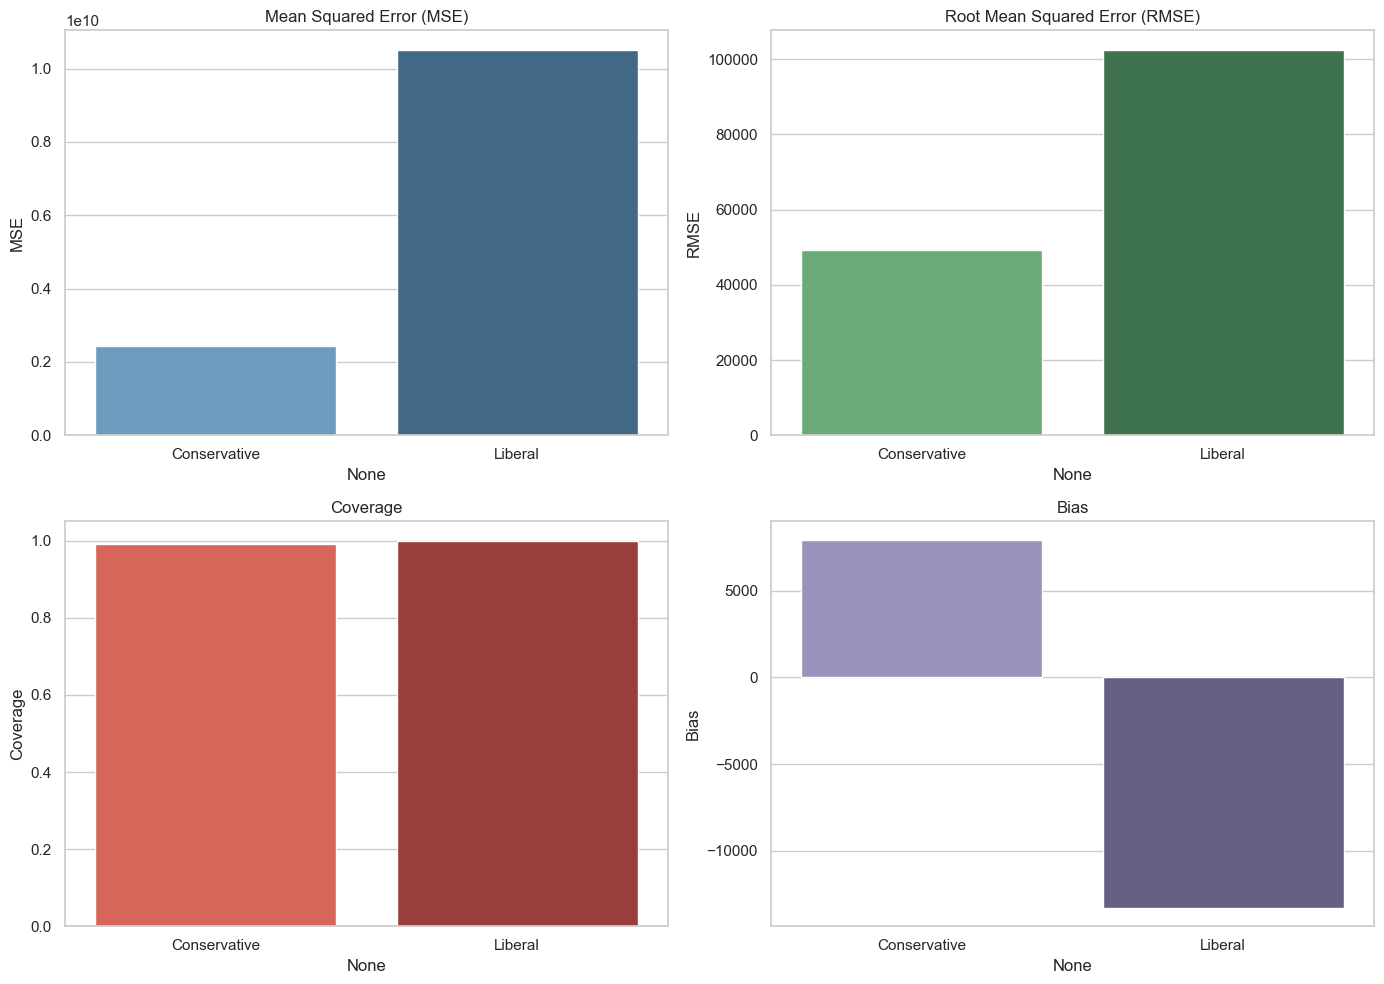

In [1550]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot MSE
sns.barplot(x=metrics_df.index, y=metrics_df['MSE'], ax=axes[0, 0], palette="Blues_d")
axes[0, 0].set_title('Mean Squared Error (MSE)')
axes[0, 0].set_ylabel('MSE')

# Plot RMSE
sns.barplot(x=metrics_df.index, y=metrics_df['RMSE'], ax=axes[0, 1], palette="Greens_d")
axes[0, 1].set_title('Root Mean Squared Error (RMSE)')
axes[0, 1].set_ylabel('RMSE')

# Plot Coverage
sns.barplot(x=metrics_df.index, y=metrics_df['Coverage'], ax=axes[1, 0], palette="Reds_d")
axes[1, 0].set_title('Coverage')
axes[1, 0].set_ylabel('Coverage')

# Plot Bias
sns.barplot(x=metrics_df.index, y=metrics_df['Bias'], ax=axes[1, 1], palette="Purples_d")
axes[1, 1].set_title('Bias')
axes[1, 1].set_ylabel('Bias')

# Adjust layout
plt.tight_layout()
plt.show()


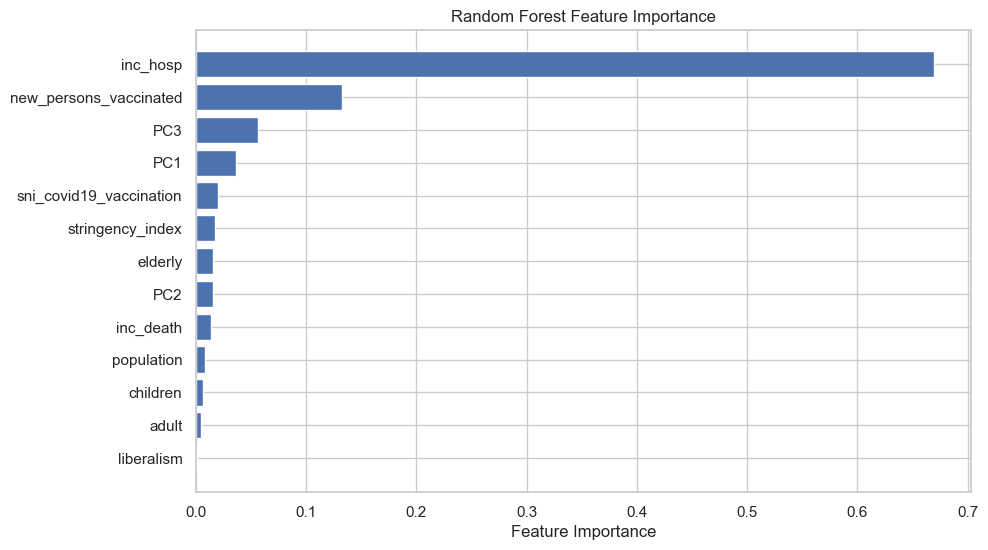

In [1551]:
# Get feature importances from the random forest model
feature_importances = rf_model.feature_importances_

# Get the names of features
feature_names = list(X.columns)

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

#### Method 2: Conditional Independent Demographic Parity

#### STEP 2.1: Create an interaction variable

In [1552]:
df['int:liberalism_stringency'] = df['liberalism'] * df['stringency_category']

display(df)

,date,location_key,inc_case,inc_hosp,inc_death,sni_covid19_vaccination,liberalism,children,adult,elderly,...,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,population,PC1,PC2,PC3,is_liberal,int:liberalism_stringency
0,2021-01,Alabama,112124.00,1.37,1.58,0.03,0.00,-0.23,-0.24,-0.20,...,-1.01,-0.71,-0.40,1.15,-0.22,-2.40,-0.26,-0.16,False,0.00
1,2021-01,Alaska,8604.00,-0.54,-0.54,1.08,1.00,-0.76,-0.76,-0.85,...,-0.90,-1.32,-0.91,1.94,-0.22,-3.20,0.42,0.07,True,2.00
2,2021-01,Arizona,262750.00,2.37,2.94,1.49,1.00,0.14,0.06,0.17,...,-1.15,-0.30,-1.67,2.11,-0.22,-3.50,0.56,-1.17,True,3.00
3,2021-01,Arkansas,80418.00,0.28,0.47,0.25,0.00,-0.46,-0.48,-0.47,...,-0.87,-0.39,-0.12,1.09,-0.22,-2.13,-0.50,-0.22,False,0.00
4,2021-01,California,1180351.00,10.21,11.82,1.10,1.00,4.45,4.49,4.09,...,-1.05,-1.86,-2.43,2.87,-0.22,-5.16,1.49,-0.31,True,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,2022-05,Virginia,14020.00,-0.45,-0.55,-1.12,1.00,0.24,0.29,0.23,...,-0.15,-0.27,0.71,-0.31,-0.10,0.27,-0.54,0.47,True,1.00
845,2022-05,Washington,15606.00,-0.45,-0.57,-1.06,1.00,0.07,0.12,0.08,...,0.54,0.01,0.42,-1.01,-0.10,1.04,-0.19,0.52,True,1.00
846,2022-05,West Virginia,1726.00,-0.54,-0.57,-1.30,0.00,-0.65,-0.64,-0.62,...,-0.26,1.60,1.08,-1.06,-0.10,1.68,-1.32,-0.81,False,0.00
847,2022-05,Wisconsin,12420.00,-0.47,-0.55,-1.24,0.00,-0.13,-0.12,-0.08,...,1.04,0.43,1.39,-1.34,-0.10,2.60,-0.46,0.82,False,0.00


#### STEP 2.2: Fit data to a random forest regressor 

In [1553]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

X = df[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_category', 'inc_death',
        'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population', 'int:liberalism_stringency']]
y = df['inc_case']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

#### STEP 2.3: Separate between red and blue states

In [1554]:
from sklearn.metrics import mean_squared_error

# Separate the prediction into two groups
df['is_liberal'] = df['liberalism'] > 0

is_liberal = df['is_liberal'].iloc[X_test.index]

# Put the actual and predicted values into a DataFrame
y_test_pred = pd.DataFrame({'actual': y_test, 'predicted': y_pred, 'is_liberal': is_liberal})

display(y_test_pred)

,actual,predicted,is_liberal
512,65893.00,99104.44,False
357,609983.00,948774.40,False
110,8302.00,11857.65,False
684,66373.00,109043.91,False
39,11107.00,10859.88,False
...,...,...,...
450,30087.00,19790.72,True
193,3856.00,4084.16,True
795,46705.00,16293.77,True
605,221513.00,154983.02,True


#### STEP 2.4: Calculate Demographic Parity

In [1555]:
# Calculated the absolute average error for liberal and conservative states
liberal_pred = y_test_pred[y_test_pred['is_liberal'] == True]
liberal_pred_error = (abs(liberal_pred['actual'] - liberal_pred['predicted'])).mean()

conservative_pred = y_test_pred[y_test_pred['is_liberal'] == False]
conservative_pred_error = (abs(conservative_pred['actual'] - conservative_pred['predicted'])).mean()

# Divide by the number of states
#liberal_average_error = liberal_pred_error / 30
#conservative_average_error = conservative_pred_error / 20

print(f"Liberal Average Error: {liberal_pred_error}")
print(f"Conservative Average Error: {conservative_pred_error}")
      
demographic_parity_diff = liberal_pred_error - conservative_pred_error
print(f"Demographic Parity Difference: {demographic_parity_diff}")

# Model's predictions are 232 cases more erroneous for liberal states compared to conservative states.

Liberal Average Error: 38356.52858208955
Conservative Average Error: 18563.465785123968
Demographic Parity Difference: 19793.062796965583


#### STEP 2.5: Calculate differences between evaluation metrics between liberal (blue) and conservative (red) states

In [1556]:
import numpy as np

def calculate_coverage_bias(actual, predicted):
    coverage = np.mean((predicted >= actual.min()) & (predicted <= actual.max()))
    bias = np.mean(predicted - actual)
    return coverage, bias

grouped_rmse = y_test_pred.groupby('is_liberal').apply(lambda x: np.sqrt(mean_squared_error(x['actual'], x['predicted'])))

grouped_coverage_bias = y_test_pred.groupby('is_liberal').apply(lambda x: pd.Series(calculate_coverage_bias(x['actual'], x['predicted']), index=['coverage', 'bias']))

grouped_mse = y_test_pred.groupby('is_liberal').apply(lambda x: mean_squared_error(x['actual'], x['predicted']))

grouped_mse, grouped_rmse, grouped_coverage_bias

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_31048/4027890205.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_rmse = y_test_pred.groupby('is_liberal').apply(lambda x: np.sqrt(mean_squared_error(x['actual'], x['predicted'])))
/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_31048/4027890205.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_coverage_bias = y_test

(is_liberal
 False    2042159253.96
 True    11959303998.24
 dtype: float64,
 is_liberal
 False    45190.26
 True    109358.60
 dtype: float64,
             coverage      bias
 is_liberal                    
 False           0.99   7575.92
 True            1.00 -12663.63)

In [1557]:
metrics_df = pd.DataFrame({
    'MSE': grouped_mse,
    'RMSE': grouped_rmse,
    'Coverage': grouped_coverage_bias['coverage'],
    'Bias': grouped_coverage_bias['bias']
})

metrics_df.index = ['Conservative', 'Liberal']

pd.set_option('display.float_format', lambda x: '%.2f' % x)

metrics_df

,MSE,RMSE,Coverage,Bias
Conservative,2042159253.96,45190.26,0.99,7575.92
Liberal,11959303998.24,109358.60,1.00,-12663.63


#### EXTRA STEP: Calculate Disparate Impact Ratio

In [1558]:
rmse_conservative = metrics_df.loc['Conservative', 'RMSE']
rmse_liberal = metrics_df.loc['Liberal', 'RMSE']

# Compute Disparate Impact (DI) ratio using RMSE
DI_ratio = rmse_conservative / rmse_liberal
print("Disparate Impact (DI) Ratio (RMSE):", DI_ratio)

# Compute Disparate Impact (DI) ratio using bias
bias_conservative = metrics_df.loc['Conservative', 'Bias']
bias_liberal = metrics_df.loc['Liberal', 'Bias']   

DI_ratio_bias = bias_conservative / bias_liberal
print("Disparate Impact (DI) Ratio (Bias):", DI_ratio_bias)

Disparate Impact (DI) Ratio (RMSE): 0.413230006987494
Disparate Impact (DI) Ratio (Bias): -0.5982420189228294


#### STEP 2.6: Calculate Disparate Impact Ratio for red and blue states based on different stringency index category

In [1559]:
interaction_groups = [
    (1, 1), (1, 2), (1, 3),  # Liberal states with stringency categories 1, 2, and 3
    (0, 1), (0, 2), (0, 3)   # Conservative states with stringency categories 1, 2, and 3
]

results = {}

for liberalism, stringency in interaction_groups:
    group_mask = (X_test['liberalism'] == liberalism) & (X_test['stringency_category'] == stringency)
    X_test_group = X_test[group_mask]
    y_test_group = y_test[group_mask]
    y_pred_group = rf_model.predict(X_test_group)

    mse_group = mean_squared_error(y_test_group, y_pred_group)

    results[(liberalism, stringency)] = mse_group

# Calculate Disparate Impact
DI = {}
for liberalism, stringency in interaction_groups:
    DI[(liberalism, stringency)] = results[(liberalism, stringency)] / results[(1-liberalism, stringency)]

# Convert results to a DataFrame
df_results = pd.DataFrame(DI.items(), columns=['Combination', 'Disparate Impact (DI)'])

print(df_results)

  Combination  Disparate Impact (DI)
0      (1, 1)                   5.38
1      (1, 2)                   7.59
2      (1, 3)                   9.90
3      (0, 1)                   0.19
4      (0, 2)                   0.13
5      (0, 3)                   0.10


#### STEP 2.7: Calculate the evaluation metrics for red and blue states based on different stringency index category

In [1560]:
interaction_groups = [
    (1, 1),
    (1, 2),
    (1, 3),
    (0, 1),
    (0, 2),
    (0, 3)
]

results = {}

for liberalism, stringency in interaction_groups:
    group_mask = (X_test['liberalism'] == liberalism) & (X_test['stringency_category'] == stringency)
    X_test_group = X_test[group_mask]
    y_test_group = y_test[group_mask]
    y_pred_group = rf_model.predict(X_test_group)

    rmse = mean_squared_error(y_test_group, y_pred_group, squared=False)
    mse = mean_squared_error(y_test_group, y_pred_group)
    bias = (y_pred_group - y_test_group).mean()
    coverage = ((y_pred_group >= y_test_group.min()) & (y_pred_group <= y_test_group.max())).mean()

    results[(liberalism, stringency)] = {
        'RMSE': rmse,
        'MSE': mse,
        'Bias': bias,
        'Coverage': coverage
    }

In [1561]:
results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['Liberalism', 'Stringency Category', 'RMSE', 'MSE', 'Bias', 'Coverage']
results_df['Liberalism'] = results_df['Liberalism'].map({0: 'Conservative', 1: 'Liberal'})

pd.set_option('display.float_format', lambda x: '%.3f' % x)

results_df

,Liberalism,Stringency Category,RMSE,MSE,Bias,Coverage
0,Liberal,1,118330.050,14002000754.310,-27755.666,0.989
1,Liberal,2,51594.732,2662016341.792,5097.110,1.000
2,Liberal,3,141378.967,19988012406.202,49467.145,0.923
3,Conservative,1,50995.847,2600576402.767,5361.483,0.989
4,Conservative,2,18730.900,350846607.198,11979.068,0.966
5,Conservative,3,44933.269,2018998669.239,24370.618,0.750


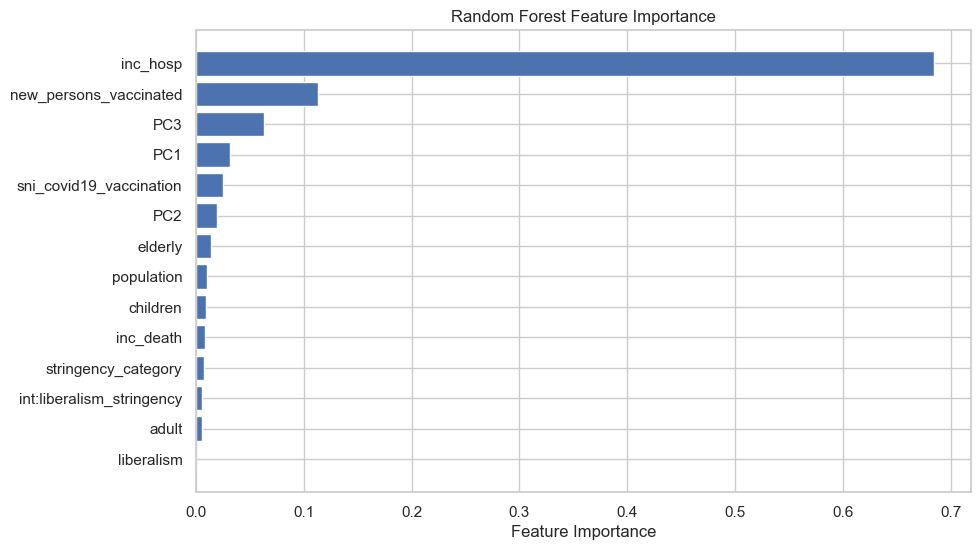

In [1562]:
# Get feature importances from the random forest model
feature_importances = rf_model.feature_importances_

# Get the names of features
feature_names = list(X.columns)

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

### Mitigating Bias

#### **STEP 1: Create a custom loss function**

In [1563]:
from sklearn.metrics import mean_absolute_error
from fairlearn.reductions import LossMoment

# Custom loss function: mean absolute error (MAE)
def custom_mae_loss(y_true, y_pred):
    return np.abs(y_true - y_pred)

#### **STEP 2: Create custom bounded group loss**

In [1564]:
# Define a custom bounded group loss for regression
class CustomBoundedGroupLoss(LossMoment):
    def __init__(self, loss_function, upper_bound):
        super().__init__(loss=loss_function)
        self.loss_function = loss_function
        self.upper_bound = upper_bound

    def load_data(self, X, y, sensitive_features):
        super().load_data(X, y, sensitive_features=sensitive_features)
        self.y = y
        self.sensitive_features = sensitive_features

    def gamma(self, predictor):
        predictions = predictor(self.X)
        losses = self.loss_function(self.y, predictions)
        group_losses = losses.groupby(self.sensitive_features).mean()
        return group_losses

#### **STEP 3: Fit to a random forest regressor**

In [1565]:
features = df[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
            'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population']]
target = df['inc_case']
state_type = df['liberalism']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, state_type_train, state_type_test = train_test_split(
    features, target, state_type, test_size=0.2, random_state=42)

# Train the random forest regressor
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#### **STEP 4: Create an instance of the custom bounded group loss with a practical upper bound**

In [1566]:
# Create an instance of the custom bounded group loss with a practical upper bound
cbgl = CustomBoundedGroupLoss(custom_mae_loss, upper_bound=19512) 
cbgl.load_data(X_test, y_test, sensitive_features=state_type_test)

#### **STEP 5: Calculate losses**

In [1567]:
# Calculate group-specific losses
group_losses = cbgl.gamma(lambda X: y_pred)

print("Group-specific loss with CustomBoundedGroupLoss:")
print(group_losses)

# Difference between group losses
group_loss_diff = group_losses[1] - group_losses[0]
print(f"Difference in group losses: {group_loss_diff}")

Group-specific loss with CustomBoundedGroupLoss:
liberalism
0.000   21823.700
1.000   35896.306
Name: inc_case, dtype: float64
Difference in group losses: 14072.605055555556


In [1568]:
from fairlearn.reductions import BoundedGroupLoss, ZeroOneLoss
from fairlearn.metrics import MetricFrame

X = df[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
            'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population']]
y = df['inc_case']
state_type = df['liberalism']

# Train random forest regressor
X_train, X_test, y_train, y_test, state_type_train, state_type_test = train_test_split(
    X, y, state_type, test_size=0.3, random_state=42)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
y_test_pred = rf_model.predict(X_test)

#### **STEP 2: Calculate overall MSE and MAE**

In [1569]:
from sklearn.metrics import mean_absolute_error

overall_mse = mean_squared_error(y_test, y_test_pred)
overall_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Overall MSE: {overall_mse}")
print(f"Overall MAE: {overall_mae}")

Overall MSE: 6700897041.129252
Overall MAE: 27931.935921568627


#### **STEP 3: Calculate state-specific MAE using MetricFrame**

In [1570]:
mae_frame = MetricFrame(metrics=mean_absolute_error,
                        y_true=y_test, y_pred=y_pred,
                        sensitive_features=pd.Series(state_type_test, name="SF 0"))

group_mae = mae_frame.by_group
print("Group-wise MAE:}", group_mae)

ValueError: Found input variables with inconsistent numbers of samples: [255, 170]

#### **STEP 4: Apply BoundedGroupLoss**

In [ ]:
bgl = BoundedGroupLoss(ZeroOneLoss(), upper_bound=0.1)
bgl.load_data(X_test, y_test, sensitive_features=state_type_test)
group_losses = bgl.gamma(lambda X: y_pred)

/opt/anaconda3/envs/cssci/lib/python3.11/site-packages/fairlearn/reductions/_moments/bounded_group_loss.py:64: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i][attr] = 1
/opt/anaconda3/envs/cssci/lib/python3.11/site-packages/f

In [ ]:
X = df[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
        'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population']]
y = df['inc_case']
sensitive_feature = df['liberalism']

# Split data into training and test sets
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X, y, sensitive_feature, test_size=0.2, random_state=42)

# Train an initial random forest regression model
baseline_model = RandomForestRegressor(random_state=42)
baseline_model.fit(X_train, y_train)

# Predict and evaluate the initial model
y_pred = baseline_model.predict(X_test)
baseline_metric_frame = MetricFrame(
    metrics=mean_squared_error,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_test
)

print("Baseline MSE per group:")
print(baseline_metric_frame.by_group)

# Calculate group-specific error adjustments
errors = y_test - y_pred
group_errors = errors.groupby(sensitive_test).mean()

# Apply group-specific adjustments to the predictions
adjusted_predictions = y_pred + sensitive_test.map(group_errors)

# Evaluate the adjusted model
adjusted_metric_frame = MetricFrame(
    metrics=mean_squared_error,
    y_true=y_test,
    y_pred=adjusted_predictions,
    sensitive_features=sensitive_test
)

print("Adjusted MSE per group:")
print(adjusted_metric_frame.by_group)

# Print overall MSE for reference
overall_mse_baseline = mean_squared_error(y_test, y_pred)
overall_mse_adjusted = mean_squared_error(y_test, adjusted_predictions)

# Calculate mean absolute error 
overall_mae_baseline = mean_absolute_error(y_test, y_pred)
overall_mae_adjusted = mean_absolute_error(y_test, adjusted_predictions)

# Calculate difference
mae_diff = overall_mae_adjusted - overall_mae_baseline
print(f"Overall MAE Difference: {mae_diff}")

print(f"Overall Baseline MSE: {overall_mse_baseline}")
print(f"Overall Adjusted MSE: {overall_mse_adjusted}")

Baseline MSE per group:
liberalism
0.000    3624539638.803
1.000   11109969162.438
Name: mean_squared_error, dtype: float64
Adjusted MSE per group:
liberalism
0.000    3485894618.647
1.000   11068487096.984
Name: mean_squared_error, dtype: float64
Overall MAE Difference: 2810.930911111107
Overall Baseline MSE: 7587414092.492202
Overall Adjusted MSE: 7500208283.648636


In [ ]:
# Define custom loss function with fairness penalty
def custom_loss(y_true, y_pred, sensitive_features, fairness_penalty):
    # Original loss (mean squared error)
    loss = np.mean((y_true - y_pred) ** 2)
    
    # Calculate fairness penalty (absolute difference between group means)
    group_mean_diff = np.abs(y_pred[sensitive_features == 1].mean() - y_pred[sensitive_features == 0].mean())
    
    # Combine original loss and fairness penalty
    total_loss = loss + fairness_penalty * group_mean_diff
    
    return total_loss

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define custom loss function with fairness penalty
def custom_loss(y_true, y_pred, sensitive_features, fairness_penalty):
    # Calculate mean predictions for each group
    mean_pred_red = np.mean(y_pred[sensitive_features == 1])
    mean_pred_blue = np.mean(y_pred[sensitive_features == 0])
    
    # Calculate fairness penalty (absolute difference between group means)
    group_mean_diff = np.abs(mean_pred_red - mean_pred_blue)
    
    # Calculate original loss (mean squared error)
    loss = np.mean((y_true - y_pred) ** 2)
    
    # Combine original loss and fairness penalty
    total_loss = loss + fairness_penalty * group_mean_diff
    
    return total_loss

X = df[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
        'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population']]
y = df['inc_case']
state_type = df['liberalism']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, state_type_train, state_type_test = train_test_split(
    X, y, state_type, test_size=0.3, random_state=42)

# Train the random forest regressor with custom loss function
fairness_penalty = 100000  # Define the fairness penalty
model = RandomForestRegressor()

# Calculate initial predictions
initial_pred = model.fit(X_train, y_train).predict(X_train)

# Train the model using the custom loss function
model.fit(X_train, y_train, sample_weight=custom_loss(y_train, initial_pred, state_type_train, fairness_penalty))

# Evaluate the trained model
y_pred = model.predict(X_test)

# Separate predictions for liberal and conservative states
liberal_predictions = y_pred[state_type_test == 1]
conservative_predictions = y_pred[state_type_test == 0]

# Calculate absolute errors for liberal and conservative states
liberal_errors = np.abs(y_test[state_type_test == 1] - liberal_predictions)
conservative_errors = np.abs(y_test[state_type_test == 0] - conservative_predictions)

# Calculate average errors for liberal and conservative states
liberal_average_error = liberal_errors.mean()
conservative_average_error = conservative_errors.mean()

print(f"Liberal Average Error: {liberal_average_error}")
print(f"Conservative Average Error: {conservative_average_error}")

# Calculate the difference in average errors for demographic parity
demographic_parity_diff = liberal_average_error - conservative_average_error
print(f"Demographic Parity Difference: {demographic_parity_diff}")


Liberal Average Error: 35534.06335820896
Conservative Average Error: 19097.740991735536
Demographic Parity Difference: 16436.32236647342


#### **STEP 1: Add interaction variables**

#### STEP 1.1: Create an interaction variable

In [ ]:
df['int:liberalism_vaccinated'] = df['liberalism'] * df['new_persons_vaccinated']
df['int:stringency_vaccinated'] = df['stringency_index'] * df['new_persons_vaccinated']
df['int:stringency_population'] = df['population'] * df['stringency_index']

display(df)

,date,location_key,inc_case,inc_hosp,inc_death,sni_covid19_vaccination,liberalism,children,adult,elderly,...,residential_percent_change_from_baseline,population,PC1,PC2,PC3,is_liberal,int:liberalism_stringency,int:liberalism_vaccinated,int:stringency_vaccinated,int:stringency_population
0,2021-01,Alabama,112124.000,1.371,1.584,0.033,0.000,-0.232,-0.237,-0.199,...,1.150,-0.216,-2.396,-0.262,-0.155,False,0.000,-0.000,-0.057,-0.109
1,2021-01,Alaska,8604.000,-0.537,-0.540,1.081,1.000,-0.755,-0.762,-0.850,...,1.940,-0.216,-3.198,0.417,0.068,True,2.000,-0.391,-0.733,-0.405
2,2021-01,Arizona,262750.000,2.367,2.944,1.492,1.000,0.135,0.060,0.166,...,2.105,-0.216,-3.499,0.563,-1.172,True,3.000,0.209,0.404,-0.416
3,2021-01,Arkansas,80418.000,0.282,0.466,0.248,0.000,-0.459,-0.484,-0.474,...,1.093,-0.216,-2.132,-0.504,-0.224,False,0.000,-0.000,-0.270,-0.385
4,2021-01,California,1180351.000,10.207,11.822,1.098,1.000,4.450,4.492,4.087,...,2.871,-0.216,-5.162,1.488,-0.310,True,3.000,3.106,7.463,-0.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,2022-05,Virginia,14020.000,-0.454,-0.553,-1.122,1.000,0.236,0.292,0.235,...,-0.307,-0.098,0.267,-0.542,0.474,True,1.000,-0.437,0.373,0.084
845,2022-05,Washington,15606.000,-0.449,-0.568,-1.060,1.000,0.072,0.117,0.084,...,-1.013,-0.098,1.036,-0.189,0.518,True,1.000,-0.468,0.322,0.068
846,2022-05,West Virginia,1726.000,-0.538,-0.568,-1.299,0.000,-0.653,-0.638,-0.616,...,-1.061,-0.098,1.682,-1.320,-0.813,False,0.000,-0.000,0.357,0.069
847,2022-05,Wisconsin,12420.000,-0.470,-0.547,-1.243,0.000,-0.127,-0.121,-0.077,...,-1.343,-0.098,2.600,-0.461,0.817,False,0.000,-0.000,0.500,0.100


#### **STEP 2: Reweight**

#### STEP 2.1: Count the number of liberal and conservative states

In [ ]:
# Calculate class frequencies
liberal_count = sum(df['liberalism'] == 1)
conservative_count = sum(df['liberalism'] == 0)

# Print the number of liberal and conservative states
print(f"Number of blue states: {liberal_count}, Number of red states: {conservative_count}")

Number of blue states: 441, Number of red states: 408


#### STEP 2.2: Fit data to a random forest regressor with class weights

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df[['sni_covid19_vaccination', 'new_persons_vaccinated', 'stringency_index', 'inc_death',
        'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population',
        'int:liberalism_vaccinated', 'int:stringency_vaccinated', 'int:stringency_population']]
y = df['inc_case']


# Split data into train and test sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, df.index, test_size=0.3, random_state=42)

# Calculate the sample weights based on the training data
liberal_count_train = sum(df.loc[train_indices]['liberalism'] == 1)
conservative_count_train = sum(df.loc[train_indices]['liberalism'] == 0)

liberal_weight_train = (1 / liberal_count_train) ** 0.5
conservative_weight_train = (1 / conservative_count_train) ** 0.5

# Assign sample weights
sample_weight_train = np.array([liberal_weight_train if label == 1 else conservative_weight_train for label in df.loc[train_indices]['liberalism']])

# Print the weights for liberal and conservative states
print(f"Weight for blue states: {liberal_weight_train}, Weight for red states: {conservative_weight_train}")

# Initialize and fit the RandomForestRegressor with sample weights
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train, sample_weight=sample_weight_train)

"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)"""

Weight for blue states: 0.05707301455353496, Weight for red states: 0.059028133610095526


'\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\nrf_model = RandomForestRegressor()\nrf_model.fit(X_train, y_train)'

In [ ]:
# Predict on the test set
y_pred = rf_model.predict(X_test)

#### STEP 2.3: Separate between red and blue states

In [ ]:
from sklearn.metrics import mean_squared_error

# Separate the prediction into two groups
df['is_liberal'] = df['liberalism'] > 0

is_liberal = df['is_liberal'].iloc[X_test.index]

# Put the actual and predicted values into a DataFrame
y_test_pred = pd.DataFrame({'actual': y_test, 'predicted': y_pred, 'is_liberal': is_liberal})

display(y_test_pred)

,actual,predicted,is_liberal
512,65893.000,86806.310,False
357,609983.000,1067356.740,False
110,8302.000,8775.850,False
684,66373.000,106666.190,False
39,11107.000,10107.310,False
...,...,...,...
450,30087.000,25006.650,True
193,3856.000,3648.070,True
795,46705.000,20223.620,True
605,221513.000,165308.390,True


#### STEP 2.4: Calculate the Demographic Parity

In [ ]:
# Calculated the absolute average error for liberal and conservative states
liberal_pred = y_test_pred[y_test_pred['is_liberal'] == True]
liberal_pred_error = (abs(liberal_pred['actual'] - liberal_pred['predicted'])).mean()

conservative_pred = y_test_pred[y_test_pred['is_liberal'] == False]
conservative_pred_error = (abs(conservative_pred['actual'] - conservative_pred['predicted'])).mean()

# Divide by the number of states
liberal_average_error = liberal_pred_error / 30
conservative_average_error = conservative_pred_error / 20

print(f"Liberal Average Error: {liberal_average_error}")
print(f"Conservative Average Error: {conservative_average_error}")
      
demographic_parity_diff = liberal_average_error - conservative_average_error
print(f"Demographic Parity Difference: {demographic_parity_diff}")

# Model's predictions are 238 cases more erroneous for liberal states compared to conservative states.

Liberal Average Error: 1204.6887089552235
Conservative Average Error: 998.8028512396695
Demographic Parity Difference: 205.88585771555404


#### STEP 2.5: Calculate differences between evaluation metrics between liberal (blue) and conservative (red) states

In [ ]:
import numpy as np

def calculate_coverage_bias(actual, predicted):
    coverage = np.mean((predicted >= actual.min()) & (predicted <= actual.max()))
    bias = np.mean(predicted - actual)
    return coverage, bias

grouped_rmse = y_test_pred.groupby('is_liberal').apply(lambda x: np.sqrt(mean_squared_error(x['actual'], x['predicted'])))

grouped_coverage_bias = y_test_pred.groupby('is_liberal').apply(lambda x: pd.Series(calculate_coverage_bias(x['actual'], x['predicted']), index=['coverage', 'bias']))

grouped_mse = y_test_pred.groupby('is_liberal').apply(lambda x: mean_squared_error(x['actual'], x['predicted']))

grouped_mse, grouped_rmse, grouped_coverage_bias

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_31048/4027890205.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_rmse = y_test_pred.groupby('is_liberal').apply(lambda x: np.sqrt(mean_squared_error(x['actual'], x['predicted'])))
/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_31048/4027890205.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_coverage_bias = y_test

(is_liberal
 False    2941578475.443
 True    10207123673.713
 dtype: float64,
 is_liberal
 False    54236.321
 True    101030.311
 dtype: float64,
             coverage      bias
 is_liberal                    
 False          0.992  6470.057
 True           1.000 -9727.133)

In [ ]:
metrics_df = pd.DataFrame({
    'MSE': grouped_mse,
    'RMSE': grouped_rmse,
    'Coverage': grouped_coverage_bias['coverage'],
    'Bias': grouped_coverage_bias['bias']
})

metrics_df.index = ['Conservative', 'Liberal']

pd.set_option('display.float_format', lambda x: '%.2f' % x)

metrics_df

,MSE,RMSE,Coverage,Bias
Conservative,2941578475.44,54236.32,0.99,6470.06
Liberal,10207123673.71,101030.31,1.00,-9727.13


#### EXTRA STEP: Calculate Disparate Impact Ratio

In [ ]:
rmse_conservative = metrics_df.loc['Conservative', 'RMSE']
rmse_liberal = metrics_df.loc['Liberal', 'RMSE']

# Compute Disparate Impact (DI) ratio using RMSE
DI_ratio = rmse_conservative / rmse_liberal
print("Disparate Impact (DI) Ratio (RMSE):", DI_ratio)

# Compute Disparate Impact (DI) ratio using bias
bias_conservative = metrics_df.loc['Conservative', 'Bias']
bias_liberal = metrics_df.loc['Liberal', 'Bias']   

DI_ratio_bias = bias_conservative / bias_liberal
print("Disparate Impact (DI) Ratio (Bias):", DI_ratio_bias)

Disparate Impact (DI) Ratio (RMSE): 0.5368321672074864
Disparate Impact (DI) Ratio (Bias): -0.665155610019886


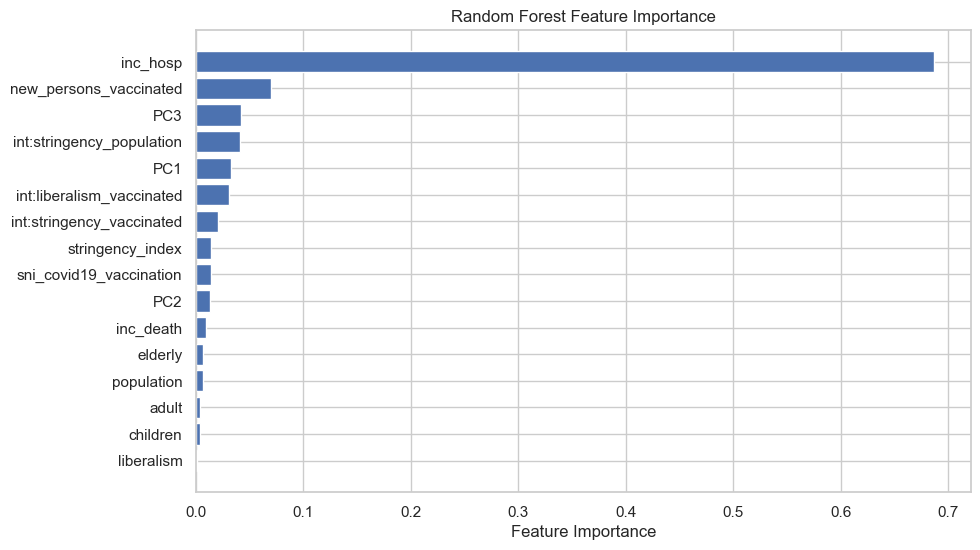

In [ ]:
# Get feature importances from the random forest model
feature_importances = rf_model.feature_importances_

# Get the names of features
feature_names = list(X.columns)

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()